# XGBoost Classifier Model

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# Load the data
df = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Data/Cleaned_Processed_Data.csv')


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Separate numericals and categoricals
numerical = ['telecommuting','has_company_logo','has_questions','description_length']
categorical = ['dominant_topic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)],
         remainder= 'passthrough')

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier())
])

# Split the data
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
xgb = pipeline.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.95      0.68      0.79       181

    accuracy                           0.98      3576
   macro avg       0.96      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

0.9818232662192393


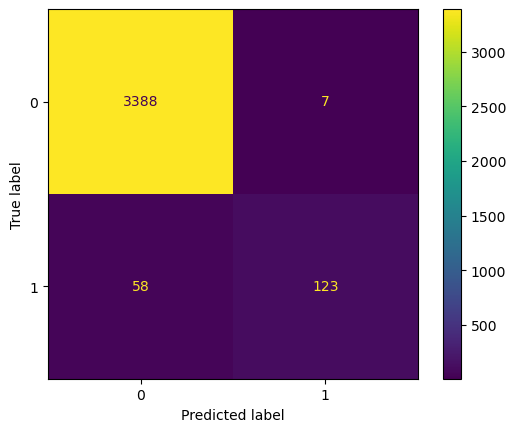

In [7]:

# Evaluate the model
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

The F1 score is 89% and 98% accuracy.

# GridSearchCV Tuning

In [12]:
param_test1 = {
    "classifier__max_depth": range(3,6,10),
    "classifier__min_child_weight": range(1,3,5),
    "classifier__subsample": [0.8,0.9],
    "classifier__n_estimators": range(100,500,1000),
    "classifier__learning_rate": [.01,.1]
}

gsearch1 = GridSearchCV(
    estimator=pipeline,  # Use the full pipeline here
    param_grid=param_test1,
    n_jobs=2,
    cv=3,
    scoring='f1'
)

gsearch1.fit(X_train, y_train)

/Users/sabrinasayed/Documents/Flatiron/Phase 5/.conda/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['telecommuting',
                                                                          'has_company_logo',
                                                                          'has_questions',
                                                                          'description_length']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dominant_topic'])])),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': range(3, 6, 10),
                         'classifier__min_child_weight': range(1, 3, 5),
                         'classifier__n_estimators': range(100, 500, 1000),
                         'classifier__subsample': [0.8, 0.9]},
             scoring='f1')

In [14]:
# Best parameters
print(gsearch1.best_params_)


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.94      0.55      0.69       181

    accuracy                           0.98      3576
   macro avg       0.96      0.77      0.84      3576
weighted avg       0.97      0.98      0.97      3576

0.9753914988814317


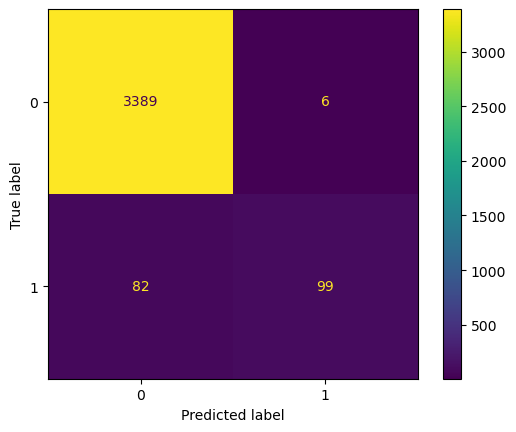

In [13]:
# Evaluate the model
y_pred = gsearch1.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(gsearch1, X_test, y_test)

The F1 score is 84% with an accuracy of 98%

In [19]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(np.exp(y_pred), np.exp(y_test))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 0.2695485365603574


### Tuning with SMOTE 

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(learning_rate=0.1, 
                                 max_depth=3,
                                 min_child_weight=1,
                                 n_estimators=100,
                                 subsample=0.8))
])

param_test2 = {
    "smote__k_neighbors": [3, 5, 7]
}

gsearch2 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_test2,
    n_jobs=2,
    cv=3,
    scoring='f1')

gsearch2.fit(X_train, y_train)

# Best parameters
print(gsearch2.best_params_)

{'smote__k_neighbors': 7}


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3395
           1       0.50      0.80      0.61       181

    accuracy                           0.95      3576
   macro avg       0.74      0.88      0.79      3576
weighted avg       0.96      0.95      0.95      3576

0.9493847874720358
RMSE: 0.3865760370737867


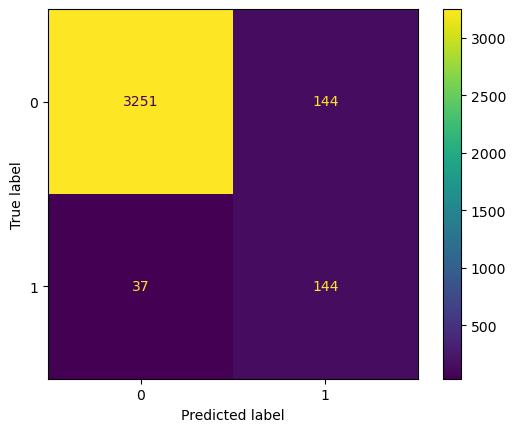

In [21]:
# Evaluate the model
y_pred_2= gsearch2.predict(X_test)
print(classification_report(y_test, y_pred_2))
print(accuracy_score(y_test, y_pred_2))
ConfusionMatrixDisplay.from_estimator(gsearch2, X_test, y_test)


mse = mean_squared_error(np.exp(y_pred_2), np.exp(y_test))
rmse2 = np.sqrt(mse)
print(f"RMSE: {rmse2}")


# XGBoost Model Evaluation

#### Despite hypertuning techniques, the original untuned model performs the best when taking into consideratoin F1 score and accuracy. The last model tuned with SMOTE has a 49% F1 score and 95% accuracy. The untuned model has a 89% F1 score and 98% accuracy.

## Best Model:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.95      0.68      0.79       181

    accuracy                           0.98      3576
   macro avg       0.96      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

0.9818232662192393
RMSE: 0.2316606766548223


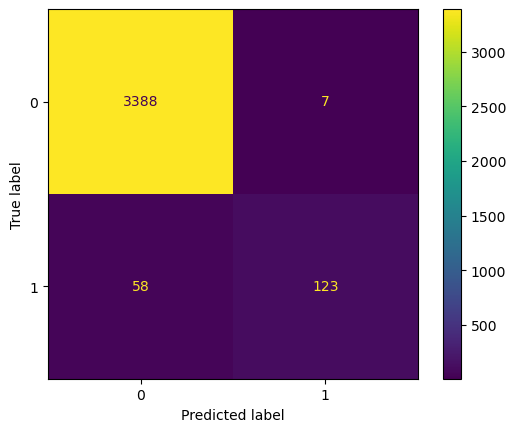

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)],
         remainder= 'passthrough')

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier())
])

# Split the data
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

mse = mean_squared_error(np.exp(y_pred), np.exp(y_test))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Model Interpretability

In [29]:
numerical

['telecommuting', 'has_company_logo', 'has_questions', 'description_length']

In [30]:
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['dominant_topic'])
print("Categorical features:", cat_feature_names)

Categorical features: ['dominant_topic_Topic 1' 'dominant_topic_Topic 10'
 'dominant_topic_Topic 2' 'dominant_topic_Topic 3'
 'dominant_topic_Topic 4' 'dominant_topic_Topic 5'
 'dominant_topic_Topic 6' 'dominant_topic_Topic 7'
 'dominant_topic_Topic 8' 'dominant_topic_Topic 9']


In [41]:
import scipy.sparse
# Get the vectorizer feature names from the remainder
# Assuming you're using TfidfVectorizer or CountVectorizer in the remainder
vectorizer_feature_names = preprocessor.get_feature_names_out()

# The vectorizer_feature_names should now contain all feature names in the correct order
# Let's verify the length matches our transformed data
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

print("Number of features:", len(vectorizer_feature_names))
print("Transformed data shape:", X_transformed.shape[1])
print("First few feature names:", vectorizer_feature_names[:20])

Number of features: 2486
Transformed data shape: 2486
First few feature names: ['num__telecommuting' 'num__has_company_logo' 'num__has_questions'
 'num__description_length' 'cat__dominant_topic_Topic 1'
 'cat__dominant_topic_Topic 10' 'cat__dominant_topic_Topic 2'
 'cat__dominant_topic_Topic 3' 'cat__dominant_topic_Topic 4'
 'cat__dominant_topic_Topic 5' 'cat__dominant_topic_Topic 6'
 'cat__dominant_topic_Topic 7' 'cat__dominant_topic_Topic 8'
 'cat__dominant_topic_Topic 9' 'remainder__ability' 'remainder__able'
 'remainder__abroad' 'remainder__academic' 'remainder__accept'
 'remainder__access']


In [ ]:
import scipy.sparse
# Get the vectorizer feature names from the remainder
# Assuming you're using TfidfVectorizer or CountVectorizer in the remainder
vectorizer_feature_names = preprocessor.get_feature_names_out()

# The vectorizer_feature_names should now contain all feature names in the correct order
# Let's verify the length matches our transformed data
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

print("Number of features:", len(vectorizer_feature_names))
print("Transformed data shape:", X_transformed.shape[1])
print("First few feature names:", vectorizer_feature_names[:20])
# Get all feature names
feature_names = preprocessor.get_feature_names_out()

# Clean up the feature names
cleaned_features = []
for name in feature_names:
    if name.startswith('num__'):
        # Remove 'num__' prefix
        cleaned_features.append(name.replace('num__', ''))
    elif name.startswith('cat__dominant_topic_'):
        # Remove 'cat__dominant_topic_' prefix
        cleaned_features.append(name.replace('cat__dominant_topic_', ''))
    elif name.startswith('remainder__'):
        # Remove 'remainder__' prefix
        cleaned_features.append(name.replace('remainder__', ''))
    else:
        cleaned_features.append(name)

# Convert to array for SHAP plot
cleaned_features = np.array(cleaned_features)

print("Number of features:", len(cleaned_features))
print("First few cleaned feature names:", cleaned_features[:20])

Number of features: 2486
First few cleaned feature names: ['telecommuting' 'has_company_logo' 'has_questions' 'description_length'
 'Topic 1' 'Topic 10' 'Topic 2' 'Topic 3' 'Topic 4' 'Topic 5' 'Topic 6'
 'Topic 7' 'Topic 8' 'Topic 9' 'ability' 'able' 'abroad' 'academic'
 'accept' 'access']


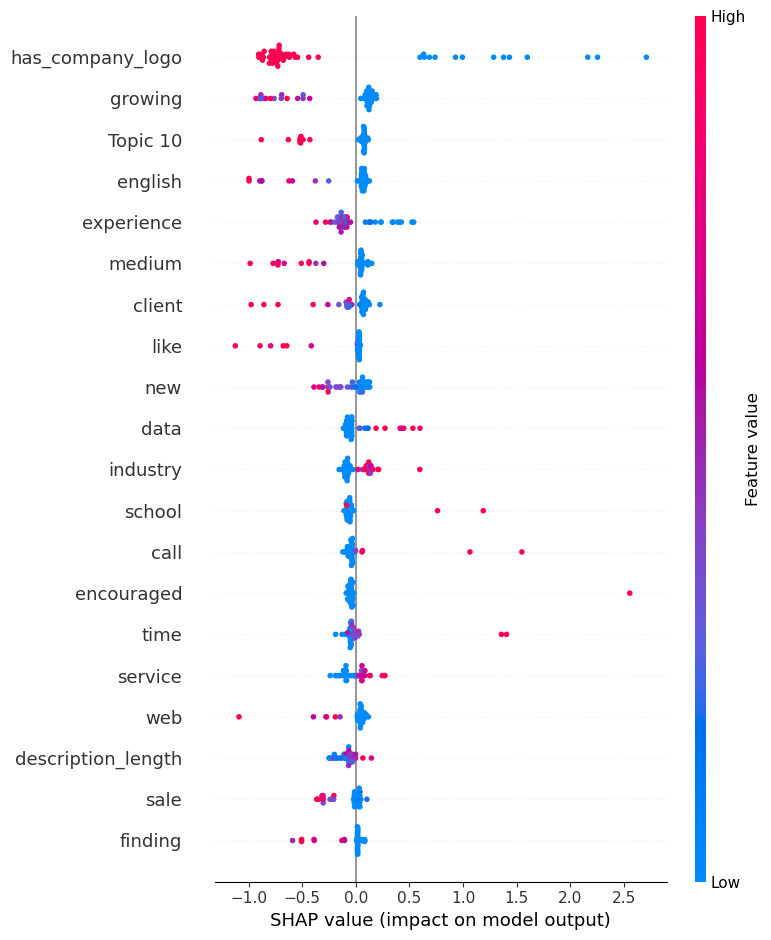

In [45]:
import shap
# Create SHAP plots with cleaned feature names
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer(X_transformed[:50])
shap.summary_plot(shap_values, X_transformed[:50], feature_names=cleaned_features)

## Interpreting SHAP Summary Plot:

Most Important Features for prediction:
- has_company_logo: when this is not present, it pushes the predictions toward fraud (positive SHAP values). This makes sence because fraudulent posts are less likely to have company logos
- growing: high usage of the word growing indicates a legitimate post
- Topic 10: includes (team, work, experience, people, new, working, company, looking, product, want). These words are common in more legitimate job posts.
- english: high usage indicates legitimate posts. 



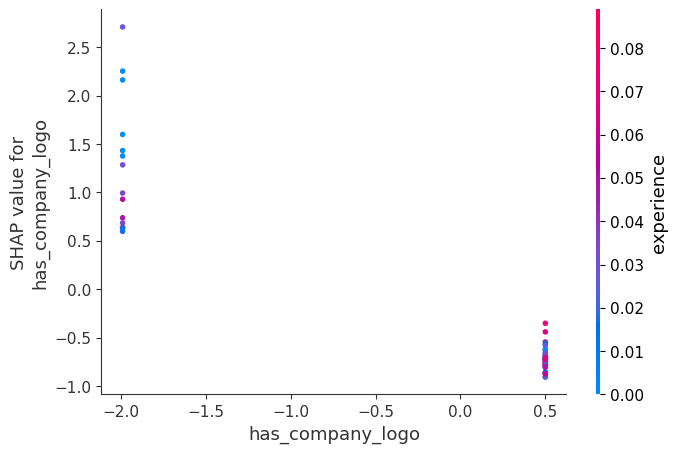

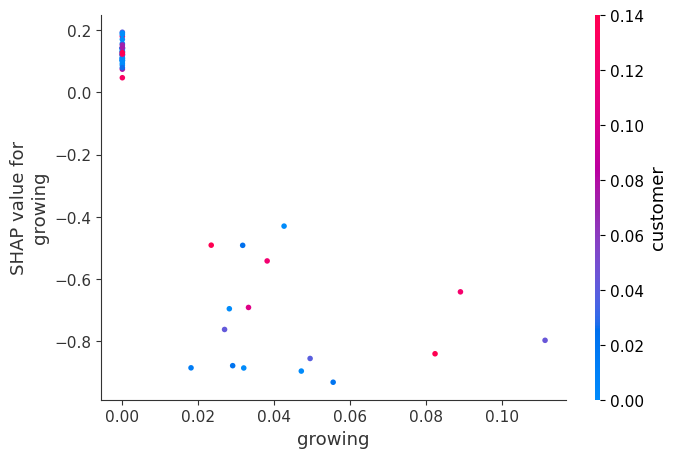

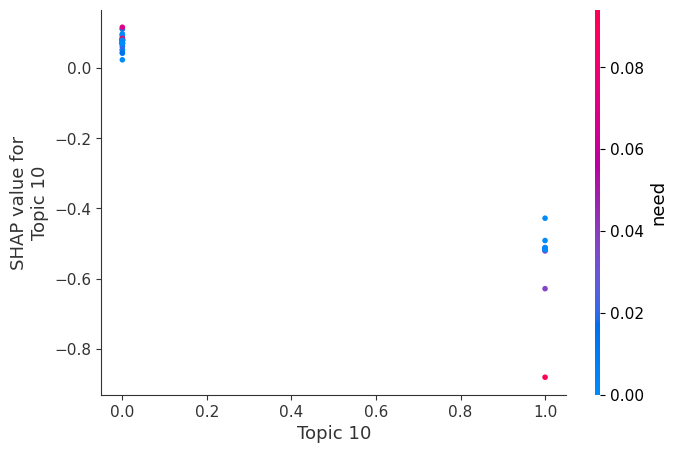

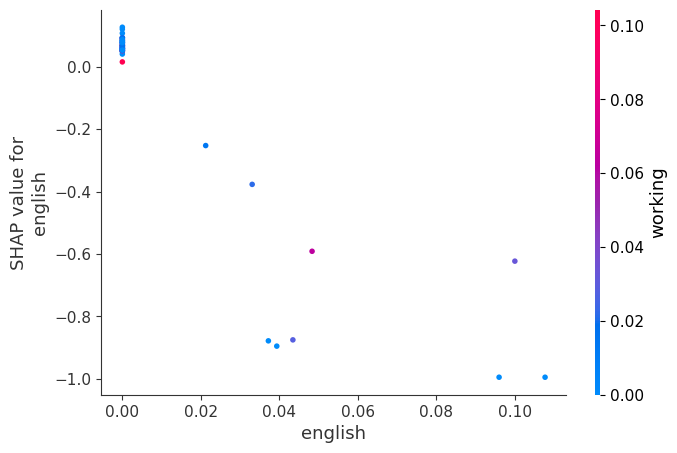

In [47]:

# Create dependence plots for top features
important_features = ["has_company_logo", "growing", "Topic 10", "english"]  # Your top features

for feature in important_features:
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_transformed[:50],
        feature_names=cleaned_features
    )

has_company_logo: When it's absent (blue), it pushes toward fraud prediction

growing: When this word appears frequently (red), it suggests legitimate job posts

Topic 10: When present (red), suggests legitimate posts

english: More English content (red) suggests legitimate posts


# Model Interpretability: LIME

In [52]:
import lime
import lime.lime_tabular

# Create a LIME explainer

X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_transformed,
    feature_names=cleaned_features, 
    class_names=['Legitimate', 'Fraudulent'],
    mode='classification'
)

In [53]:
# Function to get predictions from pipeline
def pipeline_predict_proba(X):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    return pipeline.named_steps['classifier'].predict_proba(X)

# Picking one sample to explain on
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
if scipy.sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

# Get explanation for a single instance
instance_idx = 0 
exp = explainer.explain_instance(
    X_test_transformed[instance_idx], 
    pipeline_predict_proba,
    num_features=10  # Show 10 features
)


In [54]:
# Visualize the explanation
exp.show_in_notebook()

# Print the prediction probability
print("\nActual class:", y_test.iloc[instance_idx])
print("Predicted probabilities:", pipeline_predict_proba(X_test_transformed[instance_idx]))


Actual class: 0
Predicted probabilities: [[0.9988796  0.00112038]]


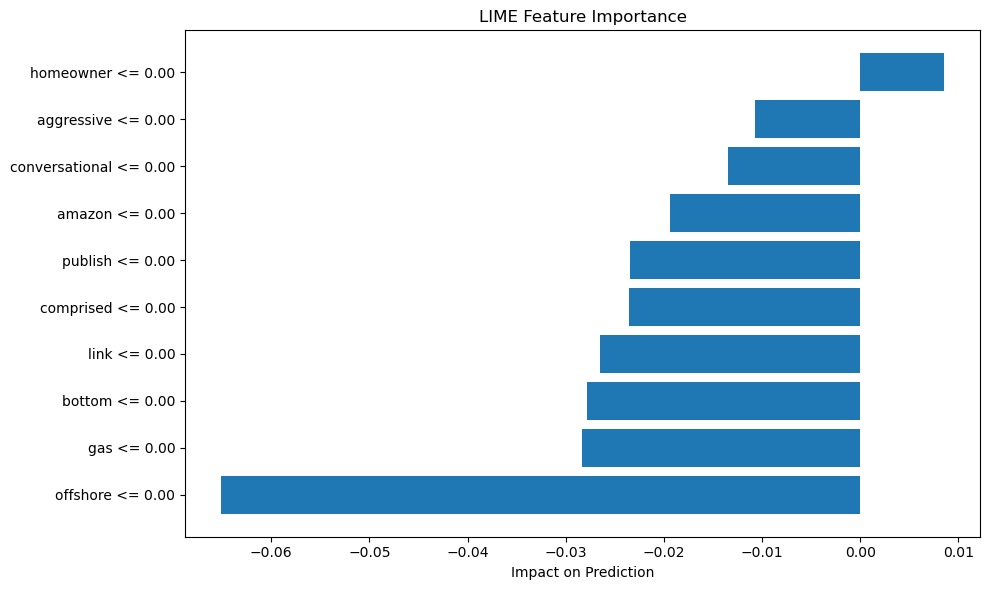

In [59]:
# Save prediction details

# Save the HTML visualization
explanation_html = exp.as_html()
with open('lime_explanation.html', 'w') as f:
    f.write(explanation_html)

# Save feature importances as CSV
feature_importance_df = pd.DataFrame(
    exp.as_list(), 
    columns=['Feature', 'Importance']
).sort_values('Importance', key=abs, ascending=False)

feature_importance_df.to_csv('feature_importances.csv', index=False)

# Plot feature importances
import matplotlib.pyplot as plt
import json

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('LIME Feature Importance')
plt.xlabel('Impact on Prediction')
plt.tight_layout()

In [60]:

# Save prediction details
prediction_summary = {
    'feature_importances': exp.as_list(),
    'class_names': exp.class_names,
    'predicted_class': exp.class_names[exp.predict_proba.argmax()],
    'prediction_probabilities': {
        'legitimate': float(exp.predict_proba[0]),  # Convert to float for JSON serialization
        'fraudulent': float(exp.predict_proba[1])
    }
}

# Save as JSON
with open('lime_explanation.json', 'w') as f:
    json.dump(prediction_summary, f, indent=2)

In [55]:
# Function to analyze specific cases
def analyze_specific_cases(condition='wrong_predictions', num_cases=5):
    """
    condition can be:
    - 'wrong_predictions': cases where model was wrong
    - 'high_confidence': cases with highest prediction confidence
    - 'low_confidence': cases with lowest prediction confidence
    """
    y_pred_proba = pipeline_predict_proba(X_test_transformed)
    
    if condition == 'wrong_predictions':
        y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)
        wrong_indices = np.where(y_pred != y_test)[0]
        indices = wrong_indices[:num_cases]
    elif condition == 'high_confidence':
        confidence = np.max(y_pred_proba, axis=1)
        indices = np.argsort(confidence)[-num_cases:]
    else:  # low_confidence
        confidence = np.max(y_pred_proba, axis=1)
        indices = np.argsort(confidence)[:num_cases]
    
    for idx in indices:
        print(f"\nAnalyzing {'Wrong' if condition == 'wrong_predictions' else 'Case'} #{idx}")
        print("-" * 50)
        exp = explainer.explain_instance(
            X_test_transformed[idx],
            pipeline_predict_proba,
            num_features=5
        )
        print(f"Actual: {'Fraudulent' if y_test.iloc[idx] == 1 else 'Legitimate'}")
        print(f"Predicted probability of fraud: {y_pred_proba[idx][1]:.3f}")
        print("\nFeature contributions:")
        for feature, value in exp.as_list():
            print(f"{feature}: {value:0.3f}")

# Analyze wrong predictions
print("Analyzing Wrong Predictions:")
analyze_specific_cases('wrong_predictions')

# Analyze high confidence predictions
print("\nAnalyzing High Confidence Predictions:")
analyze_specific_cases('high_confidence')

Analyzing Wrong Predictions:

Analyzing Wrong #18
--------------------------------------------------
Actual: Fraudulent
Predicted probability of fraud: 0.019

Feature contributions:
offshore > 0.00: 0.045
bottom <= 0.00: -0.038
gas <= 0.00: -0.030
link <= 0.00: -0.023
growing <= 0.00: 0.010

Analyzing Wrong #75
--------------------------------------------------
Actual: Fraudulent
Predicted probability of fraud: 0.010

Feature contributions:
wage <= 0.00: -0.042
gas <= 0.00: -0.031
link <= 0.00: -0.028
Topic 9 <= 0.00: -0.012
growing <= 0.00: 0.010

Analyzing Wrong #218
--------------------------------------------------
Actual: Fraudulent
Predicted probability of fraud: 0.009

Feature contributions:
gas <= 0.00: -0.041
offshore <= 0.00: -0.038
link <= 0.00: -0.031
medium > 0.00: -0.011
growing <= 0.00: 0.009

Analyzing Wrong #388
--------------------------------------------------
Actual: Fraudulent
Predicted probability of fraud: 0.071

Feature contributions:
offshore <= 0.00: -0.045
li

# Takeaways from LIME:

## Key Patterns in Wrong Predictions (False Negatives)

### Common Misclassification Features:
- The model consistently underestimates fraud probability (all < 0.3)
- Most fraudulent cases are predicted with very low fraud probabilities (0.009-0.071)
- Case #410 stands out with highest wrong prediction (0.297)

### Most Influential Features in Mistakes:
- "offshore": Appears frequently and has high impact (-0.080 to 0.045)
- "link": Consistently present (-0.023 to -0.037)
- "gas": Appears in several cases (-0.030 to -0.041)
- "growing": Small but consistent impact (around 0.010)

## High Confidence Correct Predictions (True Negatives)

### Key Features for Legitimate Predictions:
- "offshore" <= 0.00: Strongest indicator (-0.049 to -0.066)
- "link" <= 0.00: Consistent presence (-0.023 to -0.037)
- "gas" <= 0.00: Strong influence when present (-0.036)
- "administrative" <= 0.00: Appears in some cases (-0.017 to -0.025)

## Model Confusion Patterns

### Main Sources of Confusion:
- The model seems to heavily rely on the absence of certain terms
- When fraudulent posts avoid typical fraud indicators, the model fails to detect them
- The presence of legitimate-looking features can override fraud signals

### Feature Interactions:
- "growing" shows interesting behavior: sometimes indicates fraud, sometimes legitimacy
- "medium" appears in both wrong and right predictions with varying effects
- "Topic 9" appears multiple times with moderate influence


# Recommendations for Improvement:

## Feature Engineering:
- Develop compound features that combine multiple weak signals
- Add more context-aware features for offshore and link terms

## Model Adjustments:
- Adjust class weights to increase sensitivity to fraudulent cases
- Lower decision threshold for fraud classification (currently 0.5)
- Add more sophisticated text analysis features

## Data Collection:
- Gather more examples of subtle fraud cases
- Focus on cases where offshore and link appear in legitimate contexts
- Collect more data where growing is a reliable indicator of legitimacy


# Conclusion:

This model is overly simplistic in its decision making. It's mainly looking for presence/absence of individual words without any context which leads to confusing patterns. 

# Implementing Updated NLP Techniques to Model

After creating new features that are more sophisticated that include more word pairs and phrases, I will retrain the best performing model and compare the results. 

In [79]:
# Load version 2 of cleaned data
df2 = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Data/Cleaned_Processed_Data_2.csv')

In [80]:
# Separate numericals and categoricals
numerical = ['telecommuting','has_company_logo','has_questions','description_length']
categorical = ['dominant_topic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)],
         remainder= 'passthrough')

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier())
])

# Split the data
X = df2.drop('fraudulent', axis=1)
y = df2['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
xgb2 = pipeline.fit(X_train, y_train)

# Make predictions
y_pred2 = xgb2.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.98      0.69      0.81       181

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.90      3576
weighted avg       0.98      0.98      0.98      3576

0.9832214765100671


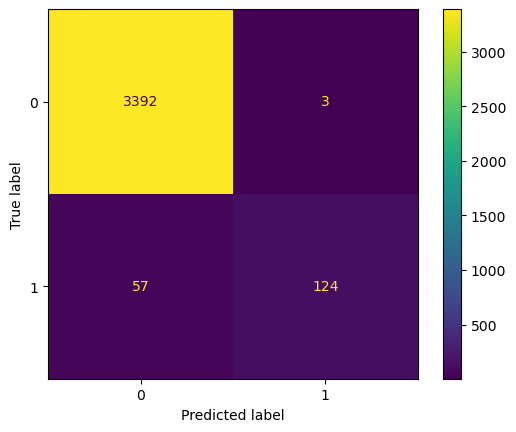

In [81]:
# Evaluate the model
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2))
ConfusionMatrixDisplay.from_estimator(xgb2, X_test, y_test)



Performance is pretty much the same. F1 score went up by 1 point.

# SHAP Interpretation #2

In [82]:
import scipy.sparse
# Get the vectorizer feature names from the remainder
# Assuming you're using TfidfVectorizer or CountVectorizer in the remainder
vectorizer_feature_names = preprocessor.get_feature_names_out()

# The vectorizer_feature_names should now contain all feature names in the correct order
# Let's verify the length matches our transformed data
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

print("Number of features:", len(vectorizer_feature_names))
print("Transformed data shape:", X_transformed.shape[1])
print("First few feature names:", vectorizer_feature_names[:20])

Number of features: 4362
Transformed data shape: 4362
First few feature names: ['num__telecommuting' 'num__has_company_logo' 'num__has_questions'
 'num__description_length' 'cat__dominant_topic_Topic 1'
 'cat__dominant_topic_Topic 10' 'cat__dominant_topic_Topic 2'
 'cat__dominant_topic_Topic 3' 'cat__dominant_topic_Topic 4'
 'cat__dominant_topic_Topic 5' 'cat__dominant_topic_Topic 6'
 'cat__dominant_topic_Topic 7' 'cat__dominant_topic_Topic 8'
 'cat__dominant_topic_Topic 9' 'remainder__title_processed_urgency_score'
 'remainder__title_processed_urgency_score.1'
 'remainder__title_processed_guarantee_score'
 'remainder__title_processed_guarantee_score.1'
 'remainder__title_processed_pressure_score'
 'remainder__title_processed_pressure_score.1']


In [83]:

# Get all feature names
feature_names = preprocessor.get_feature_names_out()

# Clean up the feature names
cleaned_features = []
for name in feature_names:
    if name.startswith('num__'):
        # Remove 'num__' prefix
        cleaned_features.append(name.replace('num__', ''))
    elif name.startswith('cat__dominant_topic_'):
        # Remove 'cat__dominant_topic_' prefix
        cleaned_features.append(name.replace('cat__dominant_topic_', ''))
    elif name.startswith('remainder__'):
        # Remove 'remainder__' prefix
        cleaned_features.append(name.replace('remainder__', ''))
    else:
        cleaned_features.append(name)

# Convert to array for SHAP plot
cleaned_features = np.array(cleaned_features)

print("Number of features:", len(cleaned_features))
print("First few cleaned feature names:", cleaned_features[:20])


Number of features: 4362
First few cleaned feature names: ['telecommuting' 'has_company_logo' 'has_questions' 'description_length'
 'Topic 1' 'Topic 10' 'Topic 2' 'Topic 3' 'Topic 4' 'Topic 5' 'Topic 6'
 'Topic 7' 'Topic 8' 'Topic 9' 'title_processed_urgency_score'
 'title_processed_urgency_score.1' 'title_processed_guarantee_score'
 'title_processed_guarantee_score.1' 'title_processed_pressure_score'
 'title_processed_pressure_score.1']


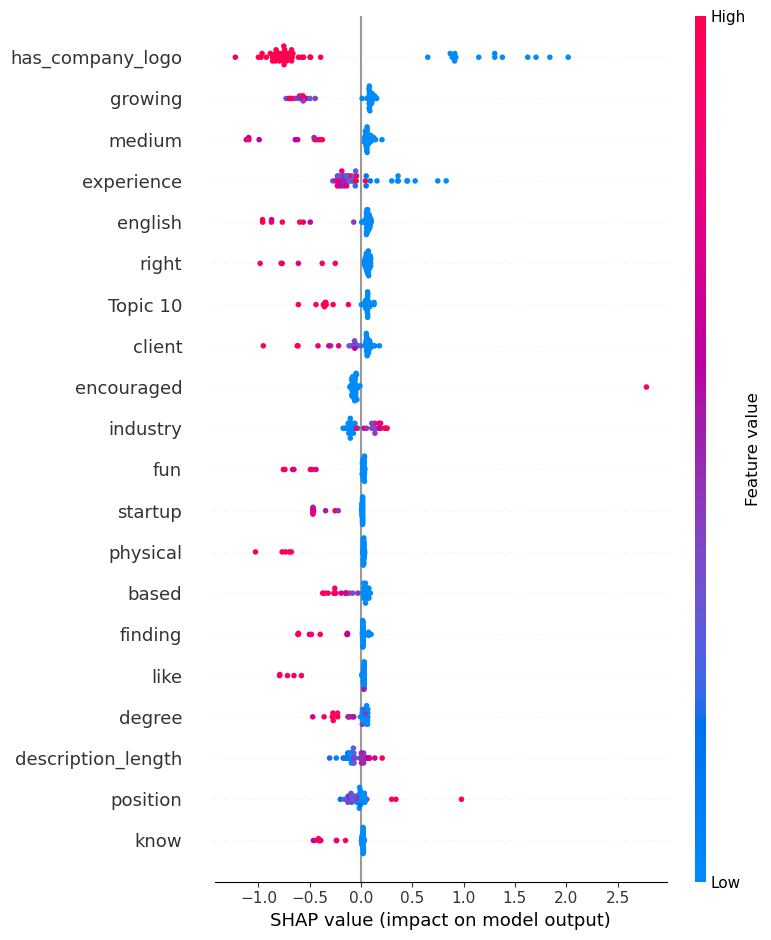

In [84]:

import shap
# Create SHAP plots with cleaned feature names
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer(X_transformed[:50])
shap.summary_plot(shap_values, X_transformed[:50], feature_names=cleaned_features)


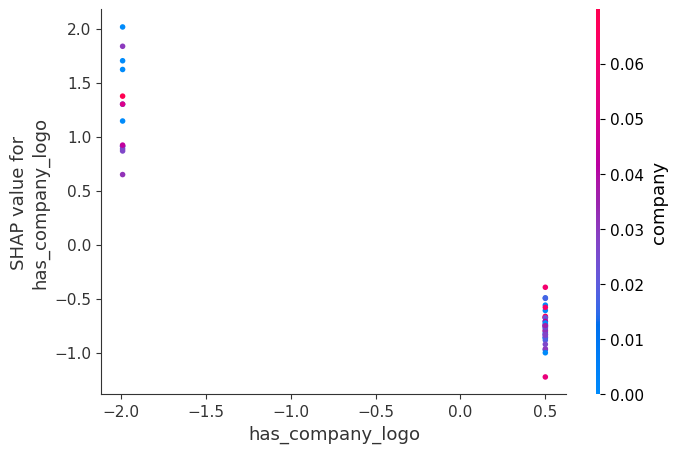

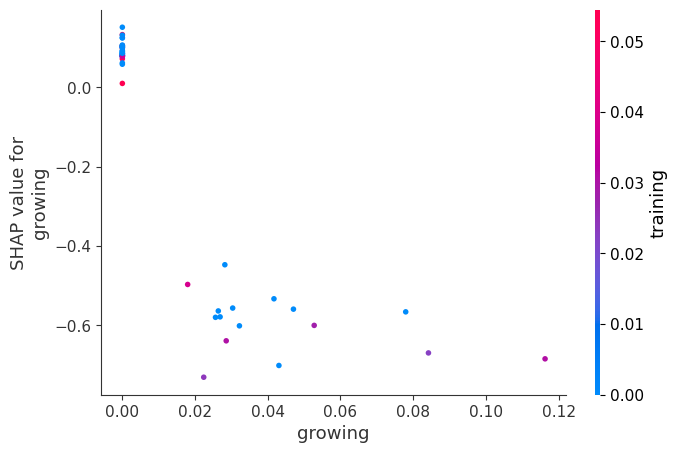

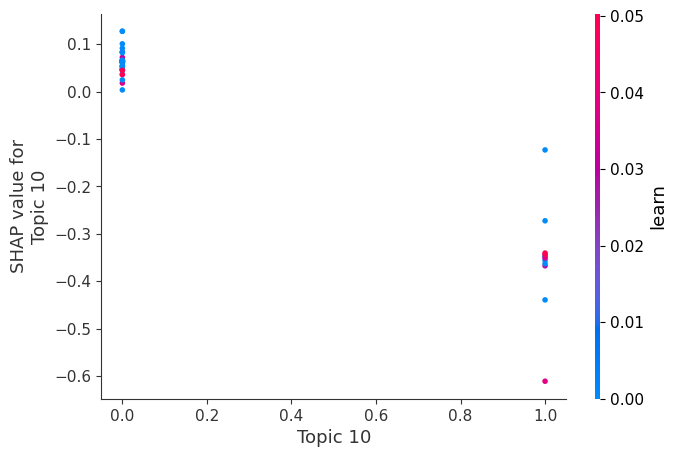

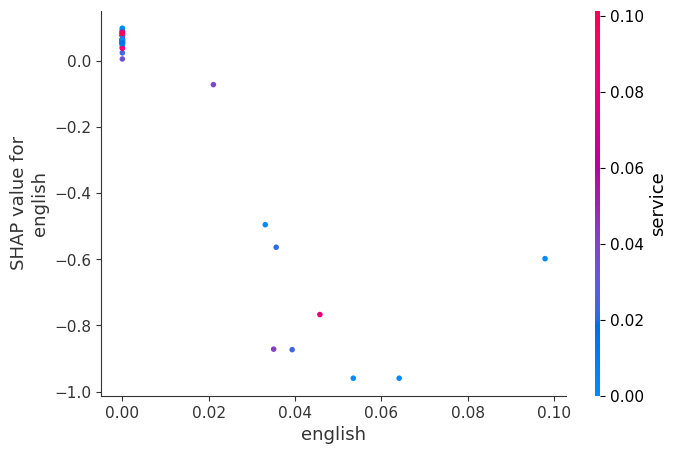

In [78]:
# Create dependence plots for top features
important_features = ["has_company_logo", "growing", "medium", "english", "experience"]  # Your top features

for feature in important_features:
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_transformed[:50],
        feature_names=cleaned_features
    )